In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster
import leafmap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from kneed import KneeLocator

In [3]:
schema = 'projects_research'
table = 'arroyovivo_residuos_hex'
query = f"SELECT * FROM {schema}.{table}"
residuos = aup.gdf_from_query(query, geometry_col='geometry')

print(residuos.shape)
residuos.head(1)

(562, 51)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity


In [4]:
residuos.columns

Index(['hex_id', 'res', 'geometry', 'aluminio', 'aluminio_quantity',
       'baterias', 'baterias_quantity', 'carton', 'carton_quantity', 'cenizas',
       'cenizas_quantity', 'ceramica', 'ceramica_quantity', 'electronica',
       'electronica_quantity', 'escombros', 'escombros_quantity', 'goma',
       'goma_quantity', 'llantas', 'llantas_quantity', 'madera',
       'madera_quantity', 'metal', 'metal_quantity', 'organico',
       'organico_quantity', 'otros', 'otros_quantity', 'papel',
       'papel_quantity', 'pesca', 'pesca_quantity', 'plastico',
       'plastico_quantity', 'salud e higiene', 'salud e higiene_quantity',
       'tabaco', 'tabaco_quantity', 'tela', 'tela_quantity', 'unicel',
       'unicel_quantity', 'vidrio', 'vidrio_quantity', 'epi', 'epi_quantity',
       'total_points', 'most_common_point', 'total_quantity',
       'most_common_quantity'],
      dtype='object')

## Dividir Data Sets en Material y Material_quantity

### DataFrame Material

In [8]:
col_material = ['hex_id', 'geometry', 'aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros',
                'goma','llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
                'tabaco','tela','unicel','vidrio','epi','total_points', 'most_common_point'] 
data_material = residuos[col_material].copy()
print(data_material.shape)
data_material.head(2)

(562, 26)


,hex_id,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,goma,...,pesca,plastico,salud e higiene,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point
0,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,0.0,36.0,0.0,10.0,1.0,21.0,0.0,...,0.0,1202.0,29.0,13.0,84.0,207.0,89.0,1.0,1918.0,Plastico
1,8a48a202978ffff,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",10.0,0.0,13.0,2.0,2.0,2.0,25.0,2.0,...,0.0,760.0,12.0,7.0,81.0,57.0,26.0,0.0,1122.0,Plastico


In [7]:
data_material.columns

Index(['hex_id', 'geometry', 'aluminio', 'baterias', 'carton', 'cenizas',
       'ceramica', 'electronica', 'escombros', 'goma', 'llantas', 'madera',
       'metal', 'organico', 'otros', 'papel', 'pesca', 'plastico',
       'salud e higiene', 'tabaco', 'tela', 'unicel', 'vidrio', 'epi',
       'total_points', 'most_common_point'],
      dtype='object')

### K-Means Clustering

### K-Value

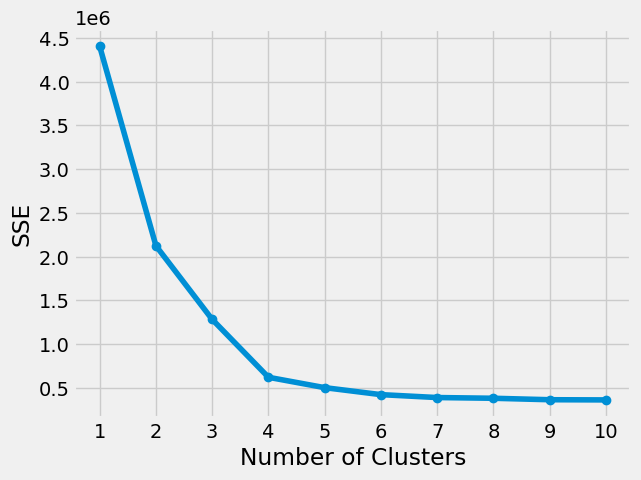

In [14]:
colclustering = ['aluminio', 'baterias', 'carton', 'cenizas', 'ceramica', 'electronica',
                           'escombros', 'goma', 'llantas', 'madera', 'metal', 'organico', 'otros',
                           'papel', 'pesca', 'plastico', 'salud e higiene', 'tabaco', 'tela', 'unicel',
                           'vidrio', 'epi']
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse = []

# Run K-means for each K and store the inertia value
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_material[colclustering])
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [21]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)
k_value = kl.elbow
print(f'El valor óptimo de clusters basado en la data que tenemos es {k_value}')

El valor óptimo de clusters basado en la data que tenemos es 4


### Cluster

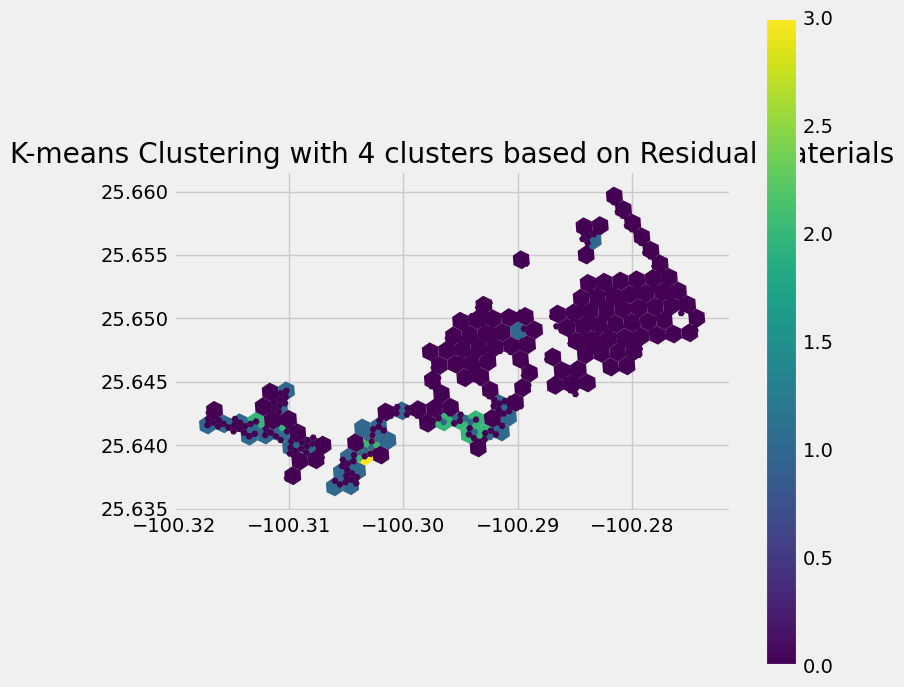

In [41]:
k =  k_value


kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
data_material['cluster'] = kmeans.fit_predict(data_material[colclustering])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))
data_material.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {k} clusters based on Residual Materials')
plt.show()

In [42]:
data_material['cluster'].unique()

array([3, 2, 1, 0], dtype=int32)

## Mapa Interactivo

In [52]:
import folium
from folium import GeoJson
import matplotlib.cm as cm
from matplotlib.colors import to_hex

# Unique values of 'Material(es)'
unique_materials = data_material['cluster'].unique()

# Create a colormap with a color for each unique value
color_map = cm.get_cmap('Accent', len(unique_materials))

# Create a color mapping dictionary
color_mapping = {material: to_hex(color_map(i)) for i, material in enumerate(unique_materials)}

# Create a function to get the color based on the 'Material(es)' value
def get_color(feature):
    material_value = feature['properties']['cluster']
    return color_mapping.get(material_value, 'gray')

# Create a map centered at the mean coordinates
m = folium.Map(location=[data_material['geometry'].centroid.y.mean(), data_material['geometry'].centroid.x.mean()], zoom_start=14.45)

# Add GeoJson layer with styling based on 'Material(es)'
geojson_layer = GeoJson(data_material,
                        style_function=lambda feature: {
                            'fillColor': get_color(feature),
                            'color': 'black',
                            'weight': 1,
                            'fillOpacity': 0.6,
                        },
                        highlight_function=lambda x: {'weight': 3, 'color': 'black'},
                        tooltip=folium.GeoJsonTooltip(fields=['most_common_point', 'cluster'], labels=True, sticky=True)
                       ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

#Save the map
#m.save("Arroyo_Vivo_MaterialesMax.html")

# Show the map
m

### DataFrame Material_quantity

In [5]:
col_qty = ['hex_id', 'geometry', 'aluminio_quantity', 'baterias_quantity', 'carton_quantity','cenizas_quantity',
                  'ceramica_quantity','electronica_quantity','escombros_quantity','goma_quantity','llantas_quantity', 
                  'madera_quantity','metal_quantity','organico_quantity','otros_quantity','papel_quantity','pesca_quantity',
                  'plastico_quantity','salud e higiene_quantity','tabaco_quantity','tela_quantity','unicel_quantity',
                  'vidrio_quantity','epi_quantity','total_quantity','most_common_quantity'] 
data_quantity = residuos[col_qty].copy()
print(data_quantity.shape)
data_quantity.head(2)

(562, 26)


,hex_id,geometry,aluminio_quantity,baterias_quantity,carton_quantity,cenizas_quantity,ceramica_quantity,electronica_quantity,escombros_quantity,goma_quantity,...,pesca_quantity,plastico_quantity,salud e higiene_quantity,tabaco_quantity,tela_quantity,unicel_quantity,vidrio_quantity,epi_quantity,total_quantity,most_common_quantity
0,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",24.0,0.0,44.0,0.0,52.0,2.0,39.0,0.0,...,0.0,1479.0,37.0,21.0,108.0,259.0,137.0,1.0,2669.0,Plastico_quantity
1,8a48a202978ffff,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",33.0,0.0,15.0,2.0,5.0,5.0,59.0,2.0,...,0.0,1640.0,38.0,7.0,170.0,238.0,55.0,0.0,2473.0,Plastico_quantity


In [6]:
data_quantity.columns

Index(['hex_id', 'geometry', 'aluminio_quantity', 'baterias_quantity',
       'carton_quantity', 'cenizas_quantity', 'ceramica_quantity',
       'electronica_quantity', 'escombros_quantity', 'goma_quantity',
       'llantas_quantity', 'madera_quantity', 'metal_quantity',
       'organico_quantity', 'otros_quantity', 'papel_quantity',
       'pesca_quantity', 'plastico_quantity', 'salud e higiene_quantity',
       'tabaco_quantity', 'tela_quantity', 'unicel_quantity',
       'vidrio_quantity', 'epi_quantity', 'total_quantity',
       'most_common_quantity'],
      dtype='object')